# General form regression using DeepLearning

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from symreg.formula import *
from symreg.simplify import *
import torch.nn.functional as F

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: False 


## Normalization

In [3]:
X = np.linspace(0, 10, 1000)
Y = 3 * np.sin(0.5 * X * X) + X - 10

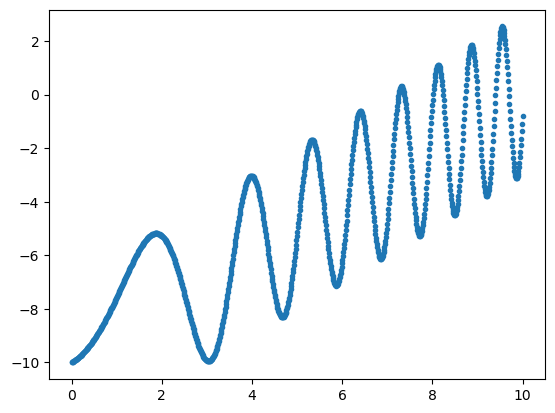

In [4]:
plt.scatter(X, Y, marker='.')
plt.show()

In [5]:
def normalize(X, Y, size: int = 100):
    """
    Min-max normalization.
    """

    x_min, x_max = np.min(X), np.max(X)
    y_min, y_max = np.min(Y), np.max(Y)

    idx = np.round(np.linspace(0, len(X) - 1, size)).astype(int)
    X_norm = ((X - x_min) / (x_max - x_min))[idx]
    Y_norm = ((Y - y_min) / (y_max - y_min))[idx]
    return X_norm, Y_norm

In [6]:
def normalize(X, Y, size: int = 100):
    """
    Z-score normalization (standardization).
    """

    idx = np.round(np.linspace(0, len(X) - 1, size)).astype(int)
    X_norm = X[idx]
    Y_norm = ((Y - np.mean(Y)) / np.std(Y))[idx]
    return X_norm, Y_norm

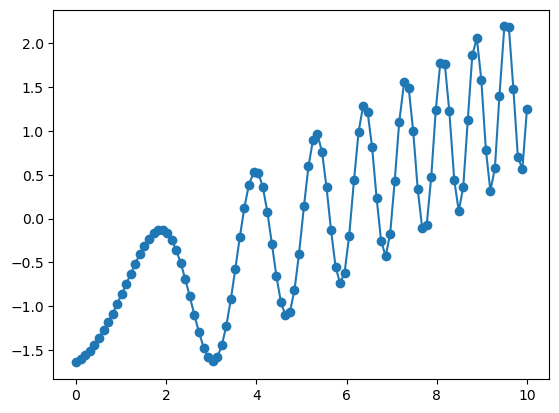

In [7]:
X_norm, Y_norm = normalize(X, Y)
plt.plot(X_norm, Y_norm)
plt.scatter(X_norm, Y_norm)
plt.show()

## Generating the dataset

In [8]:
from symreg.random import random_formula, RandomOptions

- Sinus, cosinus
- Tangent
- Divide, product
- Add, subtract
- Sqrt
- Log

```
  BINARY OPERATORS                   UNARY OPERATORS
 ADD/SUB | MUL/DIV   |   EXP | SIN | TAN | ASIN | ATAN | SQRT | LOG
```

In [9]:
from symreg.formula import ExpressionVisitor, BinaryOp, UnaryOp

class VectorVisitor(ExpressionVisitor):
    def __init__(self):
        super().__init__()
        self.vector = np.zeros(9)

    def visit_binary_expr(self, expr):
        super().visit_binary_expr(expr)

        match expr.op:
            case BinaryOp.ADD | BinaryOp.SUB:
                self.vector[0] = 1
            case BinaryOp.MUL | BinaryOp.DIV:
                self.vector[1] = 1
            case _:
                raise NotImplementedError
    
    def visit_unary_expr(self, expr):
        super().visit_unary_expr(expr)

        match expr.op:
            case UnaryOp.EXP:
                self.vector[2] = 1
            case UnaryOp.SIN:
                self.vector[3] = 1
            case UnaryOp.TAN:
                self.vector[4] = 1
            case UnaryOp.ASIN:
                self.vector[5] = 1
            case UnaryOp.ATAN:
                self.vector[6] = 1
            case UnaryOp.SQRT:
                self.vector[7] = 1
            case UnaryOp.LOG:
                self.vector[8] = 1


def generate_formula_dataset(n: int, sample_count: int = 5, max_depth=3, x_range = (-10, 10)):
    X = np.linspace(x_range[0], x_range[1], sample_count)+1e-5

    options = RandomOptions()
    options.max_depth = max_depth
    options.definition_set = X
    #print(options.allowed_unary_operators,options.allowed_unary_operators_probs)

    data = []
    labels = []

    i = 0
    while i < n:
        formula = random_formula(options)
        Y = formula(X)

        if isinstance(Y, float):
            Y = np.array([Y] * len(X))

        if np.any(np.isnan(Y)):
            continue

        eta = 1e-3 * 0
        Y += eta * np.random.normal(np.mean(Y), np.std(Y), np.shape(Y))

        X_norm, Y_norm = normalize(X, Y, sample_count)
        if np.any(np.isnan(Y_norm)):
            continue

        visitor = VectorVisitor()
        visitor.accept(formula.expr)
        data.append(np.array([X_norm,Y_norm]).T)
        labels.append(visitor.vector)
        i += 1

        if i % 500 == 2:
            print(f"Generated [{i}]")

        #if n<=5:
        #    print(formula)
        #    plt.plot(X_norm,Y_norm)
        #    plt.show()

    data = np.array(data)
    labels = np.array(labels)

    data = torch.tensor(data, dtype=torch.float32)
    labels = torch.tensor(labels[:,2:], dtype=torch.float32)

    #print(data.shape)
    #print(labels.shape)

    return data, labels


In [10]:
generate_formula_dataset(1,100, 2)

#print(random_formula(options))

(tensor([[[-10.0000,  -1.8004],
          [ -9.7980,  -1.7726],
          [ -9.5959,  -1.7445],
          [ -9.3939,  -1.7160],
          [ -9.1919,  -1.6873],
          [ -8.9899,  -1.6582],
          [ -8.7879,  -1.6288],
          [ -8.5858,  -1.5991],
          [ -8.3838,  -1.5689],
          [ -8.1818,  -1.5384],
          [ -7.9798,  -1.5076],
          [ -7.7778,  -1.4763],
          [ -7.5757,  -1.4446],
          [ -7.3737,  -1.4124],
          [ -7.1717,  -1.3798],
          [ -6.9697,  -1.3467],
          [ -6.7677,  -1.3131],
          [ -6.5656,  -1.2790],
          [ -6.3636,  -1.2443],
          [ -6.1616,  -1.2091],
          [ -5.9596,  -1.1733],
          [ -5.7576,  -1.1368],
          [ -5.5555,  -1.0996],
          [ -5.3535,  -1.0618],
          [ -5.1515,  -1.0231],
          [ -4.9495,  -0.9837],
          [ -4.7475,  -0.9434],
          [ -4.5454,  -0.9023],
          [ -4.3434,  -0.8601],
          [ -4.1414,  -0.8169],
          [ -3.9394,  -0.7725],
        

## Training

In [11]:
INPUT_SAMPLES = 100
OUTPUT_FEATURES = 7
THRESHOLD = 0.5
MAX_DEPTH = 3

In [12]:
n_train = 30000
n_test = 1000
train_data, train_labels = generate_formula_dataset(n_train, INPUT_SAMPLES, MAX_DEPTH)
dataset = TensorDataset(train_data, train_labels)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
test_data, train_labels = generate_formula_dataset(n_test, INPUT_SAMPLES, MAX_DEPTH)
datatest = TensorDataset(test_data, train_labels)
testloader = DataLoader(datatest, batch_size=32, shuffle=True)

Generated [2]


/home/nino/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/tmp/ipykernel_2518/2417782717.py:62: RuntimeWarning: invalid value encountered in multiply
  Y += eta * np.random.normal(np.mean(Y), np.std(Y), np.shape(Y))
/tmp/ipykernel_2518/1416907520.py:8: RuntimeWarning: invalid value encountered in divide
  Y_norm = ((Y - np.mean(Y)) / np.std(Y))[idx]
/home/nino/Nextcloud/Travail/Machine Learning/MLP-SymReg/symreg/formula.py:360: RuntimeWarning: overflow encountered in exp
  return self.op.value(operand)
/home/nino/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Generated [502]
Generated [1002]
Generated [1502]
Generated [2002]
Generated [2502]


/home/nino/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/nino/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:215: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


Generated [3002]
Generated [3502]
Generated [4002]
Generated [4502]
Generated [5002]
Generated [5502]
Generated [6002]
Generated [6502]
Generated [7002]
Generated [7502]
Generated [8002]
Generated [8502]
Generated [9002]
Generated [9502]
Generated [10002]
Generated [10502]
Generated [11002]
Generated [11502]
Generated [12002]
Generated [12502]
Generated [13002]
Generated [13502]
Generated [14002]
Generated [14502]
Generated [15002]
Generated [15502]


/home/nino/Nextcloud/Travail/Machine Learning/MLP-SymReg/symreg/formula.py:237: RuntimeWarning: overflow encountered in multiply
  return self.op.value(lhs, rhs)


Generated [16002]
Generated [16502]
Generated [17002]
Generated [17502]


/home/nino/Nextcloud/Travail/Machine Learning/MLP-SymReg/symreg/simplify.py:148: RuntimeWarning: overflow encountered in exp
  return ConstantExpression(expr.op.value(expr.operand.value))


Generated [18002]
Generated [18502]
Generated [19002]
Generated [19502]
Generated [20002]
Generated [20502]
Generated [21002]
Generated [21502]
Generated [22002]
Generated [22502]
Generated [23002]
Generated [23502]
Generated [24002]
Generated [24502]
Generated [25002]
Generated [25502]
Generated [26002]
Generated [26502]
Generated [27002]
Generated [27502]
Generated [28002]
Generated [28502]
Generated [29002]


/home/nino/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


Generated [29502]
Generated [2]
Generated [502]


tensor([1., 0., 0., 0., 0., 0., 0.])
tensor([1., 0., 0., 0., 1., 1., 0.])
tensor([0., 0., 0., 0., 0., 1., 0.])
tensor([0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 1., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 1., 0.])
tensor([0., 0., 0., 0., 0., 1., 0.])
tensor([0., 1., 0., 0., 0., 0., 0.])
tensor([0., 0., 1., 0., 0., 0., 1.])
tensor([0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 1., 1.])
tensor([0., 0., 1., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 1., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 1., 0., 0., 0., 0.])
tensor([0., 0., 1., 0., 1., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0.])


/tmp/ipykernel_2518/3809423843.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


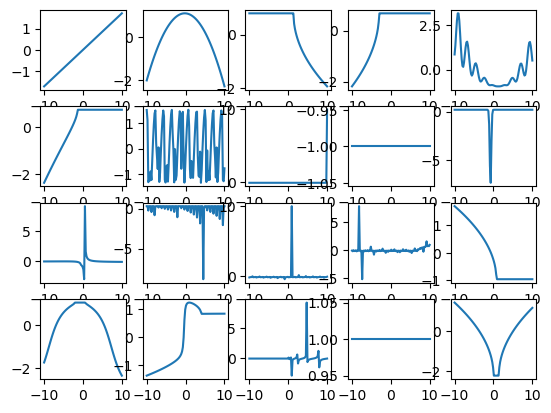

In [13]:
WIDTH, HEIGHT = 5, 4
f, ax = plt.subplots(HEIGHT, WIDTH)
for i in range(HEIGHT):
    for j in range(WIDTH):
        idx = j * HEIGHT + i
        ax[i][j].plot(train_data[idx,:,0], train_data[idx,:,1])
        print(train_labels[idx])
f.show()

In [14]:
def train_model(model, dataloader, epochs, epoch_start=1):
  model.to(device)
  model.train()

  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
  loss_fn = nn.MSELoss()

  for epoch in range(epochs):
    running_loss, running_acc = 0.0, 0
    i=0
    nans = 0
    local_n_train = n_train
    for _, data in enumerate(dataloader):
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model(inputs)
      loss = loss_fn(outputs, labels)
      if torch.isnan(loss):
        local_n_train-=len(inputs)
        nans += 1
        i+=1
        continue
      loss.backward()
      optimizer.step()

      preds = (outputs >= THRESHOLD)
      running_acc += torch.sum(preds == labels).item()
      running_loss += loss.item()
      i+=1

      if torch.isnan(outputs[0][0]):print("Un output est nan")

    print(f"[TRAIN epoch {epoch+epoch_start}]: Loss: {running_loss/local_n_train} Accuracy: {running_acc/local_n_train/OUTPUT_FEATURES}, NANs dodged: {nans}")

In [15]:
def test_model(model, dataloader):
  model.to(device)
  model.eval()

  local_n_train = n_test

  running_acc = 0.0
  with torch.no_grad():
    for _, data in enumerate(dataloader):
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)

      preds = (outputs >= THRESHOLD)
      running_acc += torch.sum(preds == labels).item()

  if local_n_train==0:print("Plus rien ne va")

  print(f"[TEST]: Accuracy: {running_acc/local_n_train/OUTPUT_FEATURES}")

In [16]:
class CNN(nn.Module):
    def __init__(self, input_samples, output_features):
        super(CNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)  # Pooling after conv1
        
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)  # Pooling after conv2
        
        # Fully connected layers
        self.fc1 = nn.Linear(32 * (input_samples // 4), 128)  # Adjust based on pooling output
        self.fc2 = nn.Linear(128, output_features)
        
    def forward(self, x):
        x = x.transpose(1, 2)
        
        # Convolutional layers + activation + pooling
        x = F.relu(self.conv1(x))  # Apply ReLU after conv1
        x = self.pool1(x)          # Apply max pooling after conv1
        
        x = F.relu(self.conv2(x))  # Apply ReLU after conv2
        x = self.pool2(x)          # Apply max pooling after conv2
        
        # Flatten the tensor before passing it to fully connected layers
        x = x.view(x.size(0), -1)  # Flatten
        
        # Fully connected layers + activation
        x = F.relu(self.fc1(x))    # Apply ReLU after fc1
        x = self.fc2(x)            # Output layer (no activation for regression or classification)
        
        return x

In [17]:
model = CNN(INPUT_SAMPLES,OUTPUT_FEATURES)
test_model(model, testloader)
for i in range(5):
    print(i)
    train_model(model, dataloader, 3, i*3+1)
    test_model(model, testloader)

[TEST]: Accuracy: 0.8081428571428572
0


/home/nino/anaconda3/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.16) or chardet (2.3.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn(


[TRAIN epoch 1]: Loss: 0.0038009443938732145 Accuracy: 0.8332095238095238, NANs dodged: 0
[TRAIN epoch 2]: Loss: 0.0033634001863499484 Accuracy: 0.8582047619047619, NANs dodged: 0
[TRAIN epoch 3]: Loss: 0.0032446917972217 Accuracy: 0.8616190476190476, NANs dodged: 0
[TEST]: Accuracy: 0.858
1
[TRAIN epoch 4]: Loss: 0.003181932586183151 Accuracy: 0.8643, NANs dodged: 0
[TRAIN epoch 5]: Loss: 0.0031329832750062146 Accuracy: 0.8657809523809524, NANs dodged: 0
[TRAIN epoch 6]: Loss: 0.0030900227098415297 Accuracy: 0.8675571428571428, NANs dodged: 0
[TEST]: Accuracy: 0.8654285714285714
2
[TRAIN epoch 7]: Loss: 0.0030604899384081364 Accuracy: 0.8683619047619048, NANs dodged: 0
[TRAIN epoch 8]: Loss: 0.0030337067854901154 Accuracy: 0.8686190476190475, NANs dodged: 0
[TRAIN epoch 9]: Loss: 0.003011867221320669 Accuracy: 0.8696428571428572, NANs dodged: 0
[TEST]: Accuracy: 0.8707142857142857
3
[TRAIN epoch 10]: Loss: 0.0029925787165760993 Accuracy: 0.8699857142857143, NANs dodged: 0
[TRAIN epoch

In [20]:
def predict(formula):
    X = np.linspace(-10, 10, INPUT_SAMPLES)
    visitor = VectorVisitor()
    visitor.accept(formula.expr)
    Y = formula(X)
    print(Y[0])
    X_norm, Y_norm = normalize(X, Y, INPUT_SAMPLES)
    Y_norm = torch.tensor(np.array([X_norm,Y_norm]).T, dtype=torch.float32).unsqueeze(0)
    preds = model(Y_norm)
    return preds / np.sqrt(np.sum((preds.detach().numpy())**2))

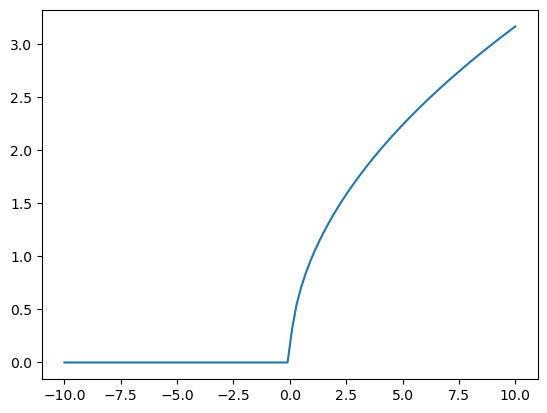

In [21]:
f = Formula(UnaryExpression(UnaryOp.SQRT, VariableExpression(0)))
X = np.linspace(-10, 10, 100)
plt.figure()
plt.plot(X, f(X))

In [22]:
print("EXP | SIN | TAN | ASIN | ATAN | SQRT | LOG")

print(predict(Formula(UnaryExpression(UnaryOp.SIN, VariableExpression(0)))))
print(predict(Formula(UnaryExpression(UnaryOp.LOG, VariableExpression(0)))))
print(predict(Formula(UnaryExpression(UnaryOp.EXP, VariableExpression(0)))))
print(predict(Formula(UnaryExpression(UnaryOp.SQRT, VariableExpression(0)))))

EXP | SIN | TAN | ASIN | ATAN | SQRT | LOG
0.5440211108893698
tensor([[1.1675e-01, 9.4743e-01, 1.8826e-02, 6.0416e-04, 1.7224e-01, 2.3732e-01,
         4.8950e-02]], grad_fn=<DivBackward0>)
0.0
tensor([[ 0.0933, -0.0233,  0.0440,  0.0013,  0.2502,  0.9024,  0.3344]],
       grad_fn=<DivBackward0>)
4.5399929762484854e-05
tensor([[8.7816e-01, 6.4234e-02, 5.2896e-02, 4.2939e-04, 1.0819e-01, 4.3334e-01,
         1.4973e-01]], grad_fn=<DivBackward0>)
0.0
tensor([[ 0.0933, -0.0233,  0.0440,  0.0013,  0.2502,  0.9024,  0.3344]],
       grad_fn=<DivBackward0>)


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


tan(x0 * 1.8155441175760583 + 2.529412327650917) * 1.9693615377204052 + -2.1864785795162445
[0. 0. 1. 0. 0. 0. 0.]
tensor([[2.2444e-01, 1.6027e-01, 9.0208e-01, 4.0537e-04, 4.2912e-02, 3.2080e-01,
         7.3679e-02]], grad_fn=<DivBackward0>)
tensor([[False, False,  True, False, False, False, False]])
1.0


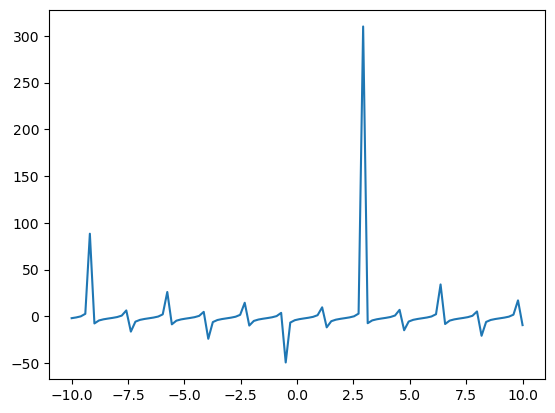

In [23]:
import torch.types

X = np.linspace(-10, 10, INPUT_SAMPLES)
options = RandomOptions()
options.max_depth = 2
options.definition_set = X

formula = random_formula(options)
visitor = VectorVisitor()
visitor.accept(formula.expr)
print(formula)
print(visitor.vector[2:])

Y = formula(X)

X_norm, Y_norm = normalize(X, Y, INPUT_SAMPLES)
Y_norm = torch.tensor(np.array([X_norm,Y_norm]).T, dtype=torch.float32).unsqueeze(0)
print(model(Y_norm) / np.sqrt(np.sum((model(Y_norm).detach().numpy())**2)) )

preds = model(Y_norm) / np.sqrt(np.sum((model(Y_norm).detach().numpy())**2)) >= THRESHOLD
print(preds)
print(np.sum(preds.detach().numpy() == visitor.vector[2:]) / OUTPUT_FEATURES)

plt.plot(X, Y)
plt.show()

In [24]:
#target_formula = Formula(UnaryExpression(UnaryOp.LOG, VariableExpression(0) + 11))
x0 = VariableExpression(0)
target_formula = Formula(sin(x0 * 2.152668455464745 + 4.0057938213474245) * 3.8996782349121286 + -4.465952186728284)
X = np.linspace(-10, 10, INPUT_SAMPLES)

EXP | SIN | TAN | ASIN | ATAN | SQRT | LOG
0


/tmp/ipykernel_2518/3498750899.py:13: RuntimeWarning: overflow encountered in square
  if np.log(np.sqrt(np.sum((generated_formula(X) - target_Y)**2)) / np.sqrt(len(X)) + 1 ) > 90:


1
2
3
4
5
6
7
8


/home/nino/Nextcloud/Travail/Machine Learning/MLP-SymReg/symreg/formula.py:237: RuntimeWarning: overflow encountered in divide
  return self.op.value(lhs, rhs)


9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96


/tmp/ipykernel_2518/1416907520.py:8: RuntimeWarning: invalid value encountered in divide
  Y_norm = ((Y - np.mean(Y)) / np.std(Y))[idx]


97
98
99
Loss sans CNN : 4.6996666758766255 std 0.01094344039549242
Loss avec CNN : 4.669677955561503 std 0.012450865648868544


/tmp/ipykernel_2518/3498750899.py:74: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


Text(0, 0.5, 'Relative improvement of the loss using the CNN (loss_CNN / loss_full_random)')

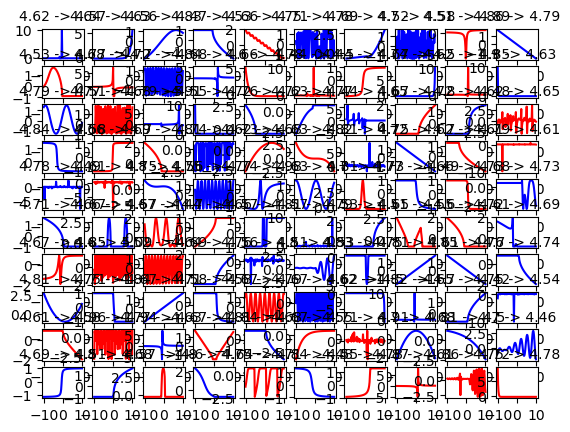

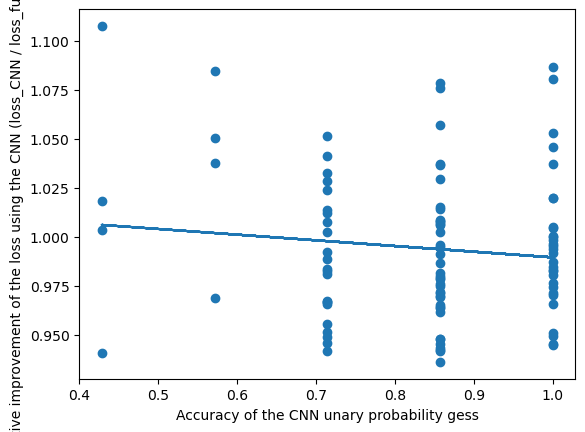

In [44]:
from symreg.generator import *
import torch.nn.functional as F

print("EXP | SIN | TAN | ASIN | ATAN | SQRT | LOG")

def predict(target_x, target_y):
    X_norm, Y_norm = normalize(target_x, target_y, 100)
    Y_norm = torch.tensor(np.array([X_norm,Y_norm]).T, dtype=torch.float32).unsqueeze(0)
    preds = model(Y_norm)
    return preds / np.sqrt(np.sum((preds.detach().numpy())**2))

def loss_compare(generated_formula, target_Y):
    if np.log(np.sqrt(np.sum((generated_formula(X) - target_Y)**2)) / np.sqrt(len(X)) + 1 ) > 90:
        return 0
    return np.log(np.sqrt(np.sum((generated_formula(X) - target_Y)**2)) / np.sqrt(len(X)) + 1 )

def test_generation_init_CNN(target_Y, proba_CNN, nb_generated):
    
    random_options = RandomOptions()
    random_options.definition_set = X
    random_options.max_depth = 3

    random_options.prob_unary_operators = np.array([1,1,1,1,1,1,1,1]) / 7
    generator = RandomGenerator(random_options)
    
    S_rd = []
    for i in range(nb_generated):
        generated_formula = generator.generate()
        S_rd.append( loss_compare(generated_formula, target_Y) ) 

    random_options.prob_unary_operators = proba_CNN.flatten().detach().numpy()
    generator = RandomGenerator(random_options)

    S_CNN = []
    for i in range(nb_generated):
        generated_formula = generator.generate()
        #plt.plot(X, generated_formula(X))
        S_CNN.append( loss_compare(generated_formula, target_Y) )

    return S_rd, S_CNN


S_rd, S_CNN = [], []
CNN_accuracy = []
loss_improvement = []

WIDTH, HEIGHT = 10, 10
f, ax = plt.subplots(HEIGHT, WIDTH)
for i in range(HEIGHT):
    for j in range(WIDTH):
        idx = i*WIDTH + j
        print(idx)
        target_XY, label = generate_formula_dataset(1, sample_count=100, max_depth=3, x_range = (-10, 10))
        target_Y = target_XY[0,:,1].numpy()
        
        proba_unary_CNN = predict(X, target_Y)
        if not np.isnan(np.sqrt(float(torch.sum((proba_unary_CNN - label)**2)))):
            #CNN_accuracy.append(np.sqrt(float(torch.sum((proba_unary_CNN - F.softmax(label, dim=1))**2))) / 7)
            CNN_accuracy.append(float(torch.sum((proba_unary_CNN > 0.5) == label)) / 7)
            
            S_rd_current, S_CNN_current = test_generation_init_CNN(target_Y, F.softmax(proba_unary_CNN, dim=1), 5000)
            S_rd.append(np.mean(S_rd_current))
            S_CNN.append(np.mean(S_CNN_current))
            if np.mean(S_rd_current) < np.mean(S_CNN_current):
                color = 'red'
            else:
                color='blue'
            ax[i][j].plot(X, target_Y, color=color)
            ax[i][j].set_title(f"{np.around(np.mean(S_rd_current), 2)} -> {np.around(np.mean(S_CNN_current), 2)}", fontsize=10)

            
            loss_improvement.append(np.mean(S_CNN_current) / np.mean(S_rd_current))
        
f.tight_layout()

print(f"Loss sans CNN : {np.mean(S_rd)} std {np.std(S_rd)/np.sqrt(len(S_rd))}")
print(f"Loss avec CNN : {np.mean(S_CNN)} std {np.std(S_CNN)/np.sqrt(len(S_CNN))}")

plt.figure()
plt.scatter(CNN_accuracy, loss_improvement)
a,b = np.polyfit(CNN_accuracy, loss_improvement, deg=1)
plt.plot(CNN_accuracy, a*np.array(CNN_accuracy) + b)
plt.xlabel("Accuracy of the CNN unary probability gess")
plt.ylabel("Relative improvement of the loss using the CNN (loss_CNN / loss_full_random)")